<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss methods for applying GPs to problems with multiple outputs

<div class="alert alert-info">

**Note:** This material is based on the 2011 paper on this topic - [Computationally Efficient Convolved Multiple Output Gaussian Processes](https://www.jmlr.org/papers/volume12/alvarez11a/alvarez11a.pdf) and the related [Gaussian Process summer school tutorial](http://gpss.cc/gpss17/slides/multipleOutputGPs.pdf) by Mauricio Alvarez.

</div>

Let us start with an example. We will first show that using a method that exploits the relationships among the multiple outputs gives better results than using a method that considers each output as an independent task. We will then discuss the details about the multi-output GP method.

In [16]:
%run Utilities.ipynb

In [18]:
# generate data
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.
#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

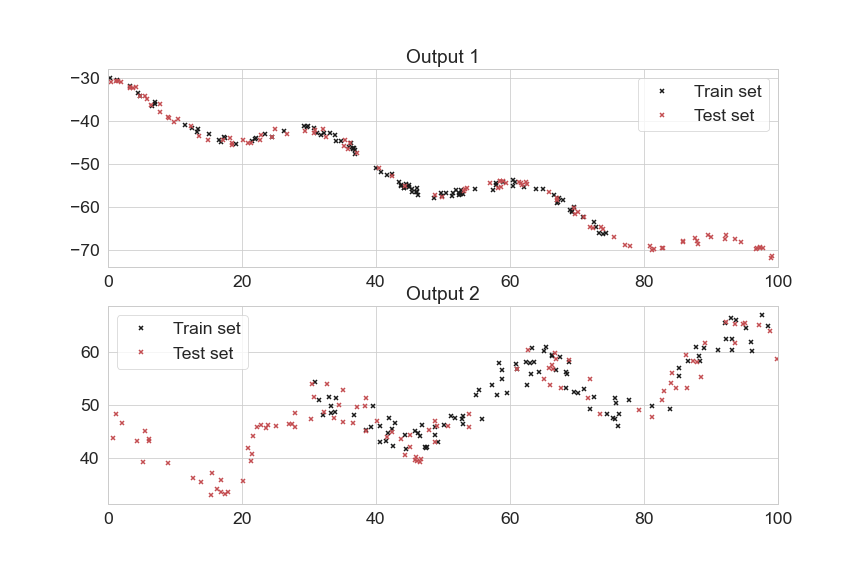

In [19]:
xlim = (0,100); ylim = (0,50)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend()

Let us first fit two independent GP models on these two outputs

(0.0, 100.0)

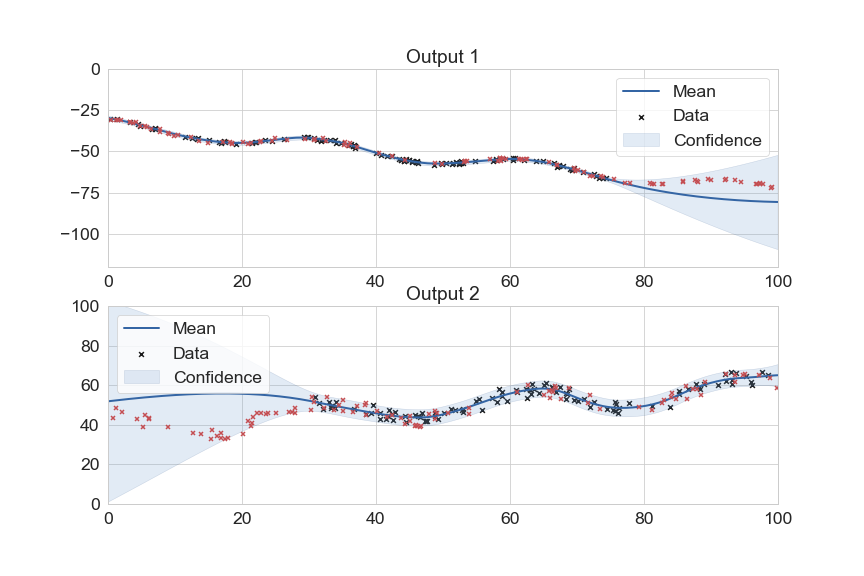

In [34]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = plt.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
ax1.set_ylim((-120,0))
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2')
ax2.set_ylim((0,100))

Clearly, the models do not perform well (high variance) in areas where the corresponding training data is not available. Now, we will see how a multi-output GP model (called ICM, more details in later sections of this notebook), improves the output.

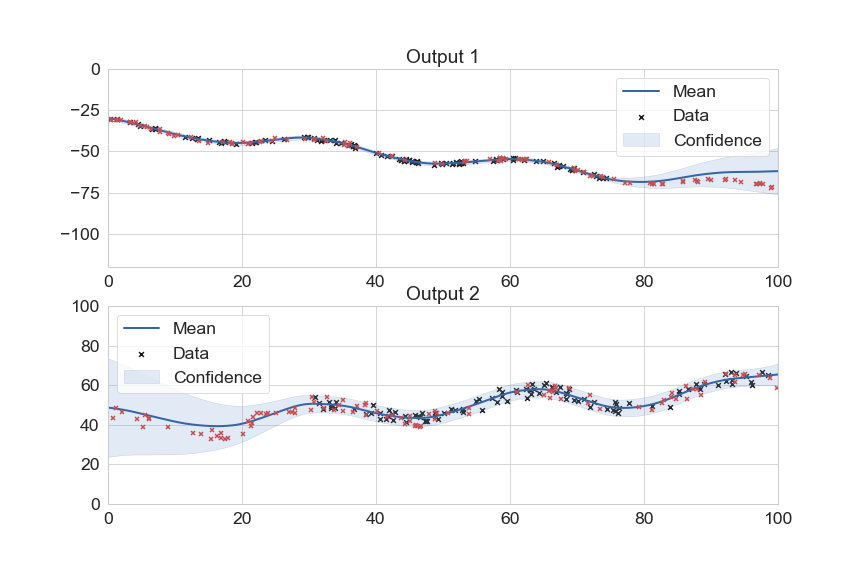

In [54]:
# model with multi-output support
K = GPy.kern.Matern32(1)
B = GPy.kern.Coregionalize(input_dim=1,output_dim=2) 
multkernel = K.prod(B,name='B.K')

icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim1=(-120,0),ylim2=(0,100))

In [56]:
print(m)


Name : gp
Objective : 355.34881355801167
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |               value  |  constraints  |  priors
  ICM.Mat32.variance                     |                 1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |   198.4485915315067  |      +ve      |        
  ICM.B.W                                |              (2, 1)  |               |        
  ICM.B.kappa                            |                (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.2817162459777306  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |   4.134995114402162  |      +ve      |        


In [60]:
print(m.ICM.B.W)
print(m.ICM.B.kappa)

  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  147.67287899  |               |        
  [1 0]  |  208.18488822  |               |        
  index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |   2191.36795075  |      +ve      |        
  [1]    |   2196.83460531  |      +ve      |        


In [67]:
W = np.array(m.ICM.B.W)

In [68]:
B = np.dot(W,W.T) + np.diag(m.ICM.B.kappa)

In [69]:
B

array([[23998.64713906, 30743.26180515],
       [30743.26180515, 45537.7822888 ]])

The independent GP models does not work well in areas where we do not have input data for either of the outputs. On the other hand, the multi-output model is able to reduce the variance in those regions, by utilizing the relationship with other output(s).

## Approaches to handle multiple outputs
There are two broad approaches:
1. **Coregionalized regression model** which  relies on the use of **multiple output kernels** or **vector-valued kernels**.
2. **Convolution processes** (CP) based approach in which a single GP process is convolved with different smoothing kernels to produce different outputs. _We will not discuss this approach in this class_. While this one seems like a more elegenat way of constructing dependent output processes, they have very high computational complexity. Approximate methods exist to handle this.

### Linear model of coregionalization or LCM
Outputs are expressed as *linear* combinations of independent Gaussian processes, which will yield a GP with a `psd` covariance function. A specific form of LCM is the **Intrinsic Coregionalization Model** or ICM, which assumes a kernel of the following form:

\begin{align*}
{\bf B}\otimes{\bf K} =
\left(\begin{array}{ccc}
B_{1,1}\times{\bf K}({\bf X}_{1},{\bf X}_{1}) & \ldots & B_{1,D}\times{\bf K}({\bf X}_{1},{\bf X}_{D})\\
\vdots & \ddots & \vdots\\
B_{D,1}\times{\bf K}({\bf X}_{D},{\bf X}_{1}) & \ldots & B_{D,D}\times{\bf K}({\bf X}_{D},{\bf X}_{D})
\end{array}\right)
\end{align*}

where ${\bf B}$ is known as the coregionalization matrix and is $(D \times D)$, where $D$ is the number of output targets. The operator $\otimes$ is also known as the _Kronecker multiplication operator_. Each ${\bf X}_i, 1 \le i \le D$ refers to the input data for the corresponding $i^{th}$ output, and ${\bf K}({\bf X}_i,{\bf X}_j)$ refers to the kernel computation between each row of ${\bf X}_i$ and each row of ${\bf X}_j$ using a kernel/covariance function. In this formulation, each ${\bf X}_i$ can have different number of rows.

Note that if $B_{i,j} = 0,\text{ for } i \ne j$, then the model is simply the independent output model.
> Verify why this is the case.

For the above ICM covariance matrix to be valid (psd), we need ${\bf K}$ to be a valid covariance matrix (which we can ensure by choosing a valid covariance function), and ${\bf B}$ to be positive semi-definite. 
> Easy to prove this: The eigenvalues of a Kronecker product ($A \otimes B$) are obtained from the product of eigenvalues of $A$ and $B$. If $A$ and $B$ are p.s.d., then all eigenvalues of $A$ and $B$ are non-negative, which means that all eigenvalues of $A\otimes B$ are also non-negative.

If we defined ${\bf B}$ as:
$$
{\bf B} = {\bf W}{\bf W}^\top + \text{diag}({\boldsymbol{\kappa}})
$$
for some $(D \times R)$ matrix, ${\bf W}$, and a $D$ length vector, $\boldsymbol{\kappa}$, then we guarantee that the ICM covariance matrix is positive semi-definite.
> It is easy to show that ${\bf B} = {\bf W}{\bf W}^\top + \text{diag}({\boldsymbol{\kappa}})$ will be positive definite.
